In [1]:
# %load_ext pycodestyle_magic
# %pycodestyle_on --ignore E402,W291,W293 --max_line_length 120

In [2]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Скачиваем файлы с Yandex Disc

In [3]:
import requests
from urllib.parse import urlencode

# ссылки на файлы
links = {'assessments': 'https://disk.yandex.ru/d/PBW7aUHGuodFDA',
         'courses': 'https://disk.yandex.ru/d/m0Z6QYNT46f9tQ',
         'student_assessment': 'https://disk.yandex.ru/d/lsmdbYB0iM7p3w',
         'student_registration': 'https://disk.yandex.ru/d/Yse4Y6RJqg_WaA',
         }

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# Получаем загрузочные ссылки на 4 файла в списке
download_urls = []
for link in links:
    final_url = base_url + urlencode(dict(public_key=links[link]))
    response = requests.get(final_url)
    download_urls.append(response.json()['href'])

In [4]:
# Считываем файлы в датафреймы
assessments = pd.read_csv(download_urls[0])
courses = pd.read_csv(download_urls[1])
student_assessment = pd.read_csv(download_urls[2])
student_registration = pd.read_csv(download_urls[3])

In [5]:
# информация об оценках в тесте
assessments

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
...,...,...,...,...,...,...
201,GGG,2014J,37443,CMA,229.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0


In [6]:
assessments.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [7]:
assessments.query("date.isna()")

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


В таблице отсутствуют данные по дате некоторых экзаменов, целям анализа это не мешает

In [8]:
# список предметов по семестрам
courses

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240
5,BBB,2014B,234
6,CCC,2014J,269
7,CCC,2014B,241
8,DDD,2013J,261
9,DDD,2014J,262


In [9]:
# результаты тестов студентов
student_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [10]:
student_assessment.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

В таблице 173 строки без данных об итогах сдачи, возможно, это записи о сданных, но еще не проверенных работах. Удалим их из таблицы.

In [11]:
# информация о времени, когда студент зарегистрировался для прохождения курса в семестре
student_registration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [12]:
student_registration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [13]:
# У студентов, окончивших курс, поле date_unregistration остается пустым.

##### 1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) 

In [14]:
# добавим в таблицу результатов сданных тестов данные по курсам и тестам
assessment_results = student_assessment.merge(assessments, on='id_assessment')

In [15]:
assessment_results.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0


In [16]:
# проверим, сдавали ли студенты тесты повторно
assessment_results.groupby(['id_student', 'id_assessment'], as_index=False) \
    .agg({'score': 'count'}) \
    .query("score > 1")

,id_student,id_assessment,score


Каждый тест сдан студентами не больше 1 раза.
Выберем из таблицы экзамены, сгруппируем по студентам и подсчитаем кол-во сданных (>= 40 баллов), 
затем из результирующей таблицы выберем студентов, сдавших только один экзамен.

In [17]:
assessment_results \
    .query("assessment_type == 'Exam' & score >= 40") \
    .groupby('id_student', as_index=False) \
    .agg({'score': 'count'}) \
    .query("score == 1") \
    .shape[0]

3802

Только один курс успешно завершили 3802 студента

2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*.
*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

Введем колонку успешности сдачи экзаменов succeed, рассчитаем среднее арифметическое по колонке

In [18]:
assessment_results['succeed'] = assessment_results.score >= 40
assessment_results \
    .query("assessment_type == 'Exam'") \
    .groupby(['code_module', 'code_presentation', 'id_assessment'], as_index=False) \
    .agg({'succeed': 'mean'})\
    .rename(columns={'succeed': 'completion_rate'}) \
    .sort_values(by='completion_rate', ascending=False)

,code_module,code_presentation,id_assessment,completion_rate
4,DDD,2014B,25361,0.925573
3,DDD,2013J,25354,0.907025
0,CCC,2014B,24290,0.888889
5,DDD,2014J,25368,0.886316
1,CCC,2014J,24299,0.872432
2,DDD,2013B,25340,0.837209


Cреди всех экзаменов самый легкий  - 25361 (DDD 2014B), самый сложный  - 25340 (DDD 2013B)

3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)

Как мы выяснили ранее, студенты не сдавали экзамены повторно.
Выберем из таблицы результатов тестов успешно сданные экзамены, сгруппируем по модулям, найдем среднее по столбцу date_submitted

In [19]:
# аналогичный результат из исходной таблицы assessment_results с номерами экзаменов
assessment_results.query("assessment_type == 'Exam' & succeed == True") \
    .groupby(['code_module'], as_index=False) \
    .agg({'date_submitted': 'mean'})  \
    .round(1)

,code_module,date_submitted
0,CCC,239.3
1,DDD,238.0


4.Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3).

In [20]:
# проверим, соответствует ли количество регистраций/отмен регистрации на курс
# количеству студентов, заявившихся/снявшихся с курса
student_registration.groupby(['code_module', 'id_student'], as_index=False) \
    .agg({'date_registration': 'count', 'date_unregistration': 'count'}) \
    .query("date_registration > 1")

,code_module,id_student,date_registration,date_unregistration
27,AAA,65002,2,1
41,AAA,94961,2,1
71,AAA,129955,2,2
80,AAA,135335,2,2
81,AAA,135400,2,1
...,...,...,...,...
29853,GGG,602997,2,2
29864,GGG,603585,2,0
30272,GGG,624767,2,1
30351,GGG,627812,2,1


In [21]:
# группируем данные регистрации по предметам, считаем кол-во уникальных регистраций
course_popularity = student_registration.query("date_registration.notna()") \
    .groupby('code_module', as_index=False) \
    .agg({'id_student': pd.Series.nunique}) \
    .sort_values(by='id_student', ascending=False) \
    .rename(columns={'id_student': 'registered'})
course_popularity

,code_module,registered
1,BBB,7683
5,FFF,7387
3,DDD,5840
2,CCC,4244
4,EEE,2858
6,GGG,2525
0,AAA,712


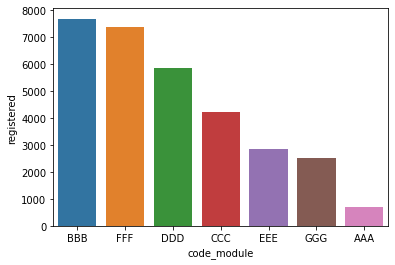

In [22]:
sns.barplot(data=course_popularity, x='code_module', y='registered')

Топ-3 популярных курсов по количеству регистраций - BBB, FFF и DDD

In [23]:
# рассчитываем кол-во регистраций и отмен регистрации
churn_data = student_registration.query("date_unregistration.notna()") \
    .groupby('code_module', as_index=False) \
    .agg({'id_student': pd.Series.nunique}) \
    .sort_values(by='id_student', ascending=False) \
    .rename(columns={'id_student': 'unregistered'})
churn_data

,code_module,unregistered
1,BBB,2314
5,FFF,2249
3,DDD,2065
2,CCC,1858
4,EEE,693
6,GGG,287
0,AAA,116


In [24]:
# курсы с самым большим оттоком:
churn_data.set_index('code_module') \
    .unregistered.nlargest(3)

code_module
BBB    2314
FFF    2249
DDD    2065
Name: unregistered, dtype: int64

Рассчитаем также относительные показатели оттока

In [25]:
# рассчитываем кол-во регистраций и отмен регистрации
registration_data = churn_data.merge(course_popularity)
registration_data

,code_module,unregistered,registered
0,BBB,2314,7683
1,FFF,2249,7387
2,DDD,2065,5840
3,CCC,1858,4244
4,EEE,693,2858
5,GGG,287,2525
6,AAA,116,712


In [26]:
# рассчитываем показатель оттока
registration_data['churn_rate'] = registration_data.unregistered / registration_data.registered

# курсы с самым большим оттоком:
registration_data.set_index('code_module') \
    .churn_rate.nlargest(3)

code_module
CCC    0.437795
DDD    0.353596
FFF    0.304454
Name: churn_rate, dtype: float64

Курсы с самым высоким абсолютным оттоком (ТОП-3): BBB, FFF и DDD. Эти же курсы лидируют по количеству регистраций.

При этом курсы ССС, DDD и FFF имеют высокие относительные показатели оттока, поэтому стоит обратить на них особое внимание и выяснить причины происходящего. В случае с наиболее популярными курсами (DDD и FFF) причины, более вероятно, связаны с недостатками самих курсов, нежели с недостатком мотивации аудитории (несоответствие курса запросам аудитории, технические недостатки, слишком сложные или слишком простые задания и др.).

5. Когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выявим семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов

In [27]:
# рассчитаем завершаемость курсов в группировке по семестрам
# (выберем результаты сдачи экзаменов и расссчитаем среднее по столбцу succeed)
completion_by_cohorts = assessment_results \
        .query("assessment_type == 'Exam'") \
        .groupby('code_presentation', as_index=False) \
        .agg({'succeed': 'mean'}) \
        .rename(columns={'succeed': 'completion_rate'}) \
        .sort_values(by='completion_rate') \
        .round(3)

In [28]:
# средние сроки сдачи курсов внутри семестров
# (выбираем успешно сданные экзамены и находим среднее по столбцу date_submitted)
submission_time_by_cohorts = assessment_results \
    .query("assessment_type == 'Exam' & succeed") \
    .groupby('code_presentation', as_index=False) \
    .agg({'date_submitted': 'mean'}) \
    .rename(columns={'date_submitted': 'mean_submission_time'}) \
    .sort_values(by='mean_submission_time', ascending=False) \
    .round(1)

In [29]:
cohorts = completion_by_cohorts.merge(submission_time_by_cohorts)
cohorts

,code_presentation,completion_rate,mean_submission_time
0,2013B,0.837,230.2
1,2014J,0.879,243.7
2,2014B,0.904,233.0
3,2013J,0.907,239.5


Семестр с самой низкой завершаемостью курсов - 2013B, c самыми долгими средними сроками сдачи курсов - 2014J.

6. Для целей построения RFM-кластеров студентов рассмотрим метрики:

R - среднее время сдачи одного экзамена, 
F - завершаемость курсов, 
M - среднее количество баллов, получаемое за экзамен. 

In [30]:
# сформируем таблицу, сгруппировав данные по студентам, и рассчитаем необходимые показатели
rfm_table = assessment_results.query("assessment_type == 'Exam'") \
    .groupby(['id_student'], as_index=False) \
    .agg({'date_submitted': 'mean', 'succeed': 'mean', 'score': 'mean'}) \
    .rename(columns={'date_submitted': 'R_date_submitted',
                     'succeed': 'F_course_completion',
                     'score': 'M_mean_exam_score'})

In [31]:
rfm_table.head()

,id_student,R_date_submitted,F_course_completion,M_mean_exam_score
0,23698,243.0,1.0,80.0
1,24213,236.0,1.0,58.0
2,27116,243.0,1.0,96.0
3,28046,237.0,1.0,40.0
4,28787,243.0,1.0,44.0


Рассмотрим расспределения полученных данных, чтобы выделить в каждом три сегмента

##### R - среднее время сдачи одного экзамена

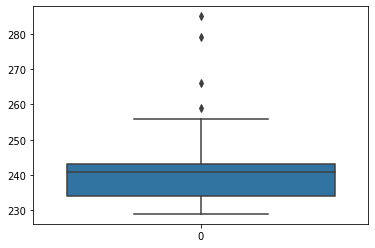

In [32]:
sns.boxplot(data=rfm_table.R_date_submitted)

In [33]:
rfm_table.R_date_submitted.describe(percentiles=[0.33, 0.67])

count    4633.000000
mean      238.462227
std         5.653378
min       229.000000
33%       236.000000
50%       241.000000
67%       243.000000
max       285.000000
Name: R_date_submitted, dtype: float64

Так как распределение неравномерно и скошено вправо, разделение диапазона значений на 3 равных интервала нецелесообразно. Примем разделение на сегменты, содержащие сопоставимое количество значений:

1- от 229 до 236 дней (33-ий процентиль) - ранняя сдача

2 - от 235 до 243 дней (67-ой процентиль) - средняя сдача

3 - от 244 до 285 дней - поздняя сдача

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


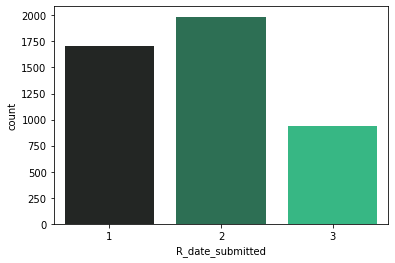

In [34]:
sns.countplot(pd.cut(rfm_table.R_date_submitted, 
                     bins=[228, 236, 243, 285], labels=['1', '2', '3']), palette='dark:#2C8')

##### F - завершаемость курсов

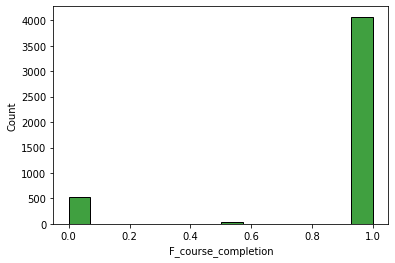

In [35]:
sns.histplot(data=rfm_table.F_course_completion, color='g')

In [36]:
rfm_table.F_course_completion.value_counts()

1.0    4069
0.0     536
0.5      28
Name: F_course_completion, dtype: int64

В данном случае примем разделение диапазона значений на 3 равных интервала:

3 - до 0,333 - низкая завершаемость (сюда попадут студенты с незавершенными курсами)

2 - от 0,334 до 0,667 - средняя завершаемость(в этом сегменте - студенты, завершившие половину курсов)

1 - от 0,668 до 1 - высокая завершаемость (из данного распределения сюда попадут студенты, успешно завершившие все курсы)

##### M - среднее количество баллов, получаемое за экзамен. 

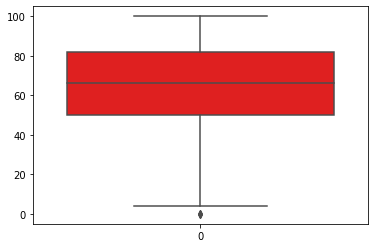

In [37]:
sns.boxplot(data=rfm_table.M_mean_exam_score, color='r')

In [38]:
rfm_table.M_mean_exam_score.describe(percentiles=[0.33, 0.67])

count    4633.000000
mean       65.117958
std        20.470561
min         0.000000
33%        56.000000
50%        66.000000
67%        76.000000
max       100.000000
Name: M_mean_exam_score, dtype: float64

В данном случае учтем разделение диапазона значений на 3 равных интервала, но низкий уровень ограничим 40 баллами, так как это - критерий успешности сдачи экзамена:

3 - до 40 - низкие баллы за экзамены

2 - от 41 до 76 - средние баллы за экзамены (67-ой процентиль)

1 - от 77 до 100 - высокие баллы за экзамены

In [39]:
# добавляем разделение по диапазонам в таблицу
rfm_table['R'] = pd.cut(rfm_table.R_date_submitted, bins=[228, 236, 243, 285], labels=['1', '2', '3'])
rfm_table['F'] = pd.cut(rfm_table.F_course_completion, bins=3, labels=['3', '2', '1'])
rfm_table['M'] = pd.cut(rfm_table.M_mean_exam_score, bins=[-1, 40, 76, 100], labels=['3', '2', '1'])
rfm_table = rfm_table.astype({'R': 'object', 'F': 'object', 'M': 'object'})
rfm_table

,id_student,R_date_submitted,F_course_completion,M_mean_exam_score,R,F,M
0,23698,243.0,1.0,80.0,2,1,1
1,24213,236.0,1.0,58.0,1,1,2
2,27116,243.0,1.0,96.0,2,1,1
3,28046,237.0,1.0,40.0,2,1,3
4,28787,243.0,1.0,44.0,2,1,2
...,...,...,...,...,...,...,...
4628,2694886,236.0,1.0,69.0,1,1,2
4629,2694933,230.0,1.0,73.0,1,1,2
4630,2695608,237.0,1.0,73.0,2,1,2
4631,2697181,230.0,1.0,80.0,1,1,1


In [40]:
# добавляем столбец с кластерами
rfm_table['RFM'] = rfm_table.R + rfm_table.F + rfm_table.M

In [41]:
rfm_table.head()

,id_student,R_date_submitted,F_course_completion,M_mean_exam_score,R,F,M,RFM
0,23698,243.0,1.0,80.0,2,1,1,211
1,24213,236.0,1.0,58.0,1,1,2,112
2,27116,243.0,1.0,96.0,2,1,1,211
3,28046,237.0,1.0,40.0,2,1,3,213
4,28787,243.0,1.0,44.0,2,1,2,212


Напишем функцию для итерпретации кластеров в столбце RFM (добавим информацию о сегментах и их границах)

In [42]:
# словари со значениями сегментов и их границами
r = {
    '1': ('ранний срок сдачи', '228 - 236 дней'),
    '2': ('средний срок сдачи', '235 - 243 дней'),
    '3': ('поздний срок сдачи', '244 - 285 дней')}

f = {
    '1': ('высокая завершаемость', 'от 0,668 до 1'),
    '2': ('средняя завершаемость', 'от 0,334 до 0,667'),
    '3': ('низкая завершаемость', 'до 0,333')}

m = {
    '1': ('высокие баллы', 'от 77 до 100 баллов'),
    '2': ('средние баллы', 'от 41 до 76 баллов'),
    '3': ('низкие баллы', 'до 40 баллов')}


# функция, возвращающая интерпретацию кластера
def definitions(row):
    return (r[row[0]], f[row[1]], m[row[2]])


# добавим столбец с описанием кластера
rfm_table['cluster_def'] = rfm_table['RFM'].apply(definitions)

In [43]:
rfm_table.head()

,id_student,R_date_submitted,F_course_completion,M_mean_exam_score,R,F,M,RFM,cluster_def
0,23698,243.0,1.0,80.0,2,1,1,211,"((средний срок сдачи, 235 - 243 дней), (высока..."
1,24213,236.0,1.0,58.0,1,1,2,112,"((ранний срок сдачи, 228 - 236 дней), (высокая..."
2,27116,243.0,1.0,96.0,2,1,1,211,"((средний срок сдачи, 235 - 243 дней), (высока..."
3,28046,237.0,1.0,40.0,2,1,3,213,"((средний срок сдачи, 235 - 243 дней), (высока..."
4,28787,243.0,1.0,44.0,2,1,2,212,"((средний срок сдачи, 235 - 243 дней), (высока..."


Text(0.5, 1.0, 'RFM_analysis: clusters of students')

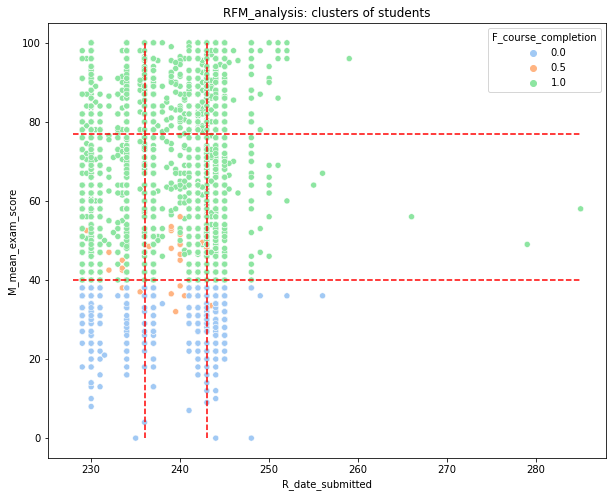

In [44]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=rfm_table,
                x='R_date_submitted',
                y='M_mean_exam_score',
                hue='F_course_completion',
                palette='pastel')

plt.vlines((236, 243), ymin=0, ymax=100, linestyle='--', colors='r')
plt.hlines((40, 77), xmin=228, xmax=285, linestyle='--', colors='r')

plt.title('RFM_analysis: clusters of students')

In [45]:
for cluster in sorted(rfm_table.RFM.unique()):
    print(f'Кластер "{cluster}": {definitions(cluster)}\n')

Кластер "111": (('ранний срок сдачи', '228 - 236 дней'), ('высокая завершаемость', 'от 0,668 до 1'), ('высокие баллы', 'от 77 до 100 баллов'))

Кластер "112": (('ранний срок сдачи', '228 - 236 дней'), ('высокая завершаемость', 'от 0,668 до 1'), ('средние баллы', 'от 41 до 76 баллов'))

Кластер "113": (('ранний срок сдачи', '228 - 236 дней'), ('высокая завершаемость', 'от 0,668 до 1'), ('низкие баллы', 'до 40 баллов'))

Кластер "122": (('ранний срок сдачи', '228 - 236 дней'), ('средняя завершаемость', 'от 0,334 до 0,667'), ('средние баллы', 'от 41 до 76 баллов'))

Кластер "123": (('ранний срок сдачи', '228 - 236 дней'), ('средняя завершаемость', 'от 0,334 до 0,667'), ('низкие баллы', 'до 40 баллов'))

Кластер "133": (('ранний срок сдачи', '228 - 236 дней'), ('низкая завершаемость', 'до 0,333'), ('низкие баллы', 'до 40 баллов'))

Кластер "211": (('средний срок сдачи', '235 - 243 дней'), ('высокая завершаемость', 'от 0,668 до 1'), ('высокие баллы', 'от 77 до 100 баллов'))

Кластер "212": 